# Exercise 2: Measurement Error Mitigation

Present day quantum computers are subject to noise of various kinds. The principle behind error mitigation is to reduce the effects from a specific source of error.  Here we will look at mitigating measurement errors, i.e., errors in determining the correct quantum state from measurements performed on qubits.

<img src="mitigation.png" width="900"/>
<center>Measurement Error Mitigation</center>

In the above picture, you can see the outcome of applying measurement error mitigation. On the left, the histogram shows results obtained using the device `ibmq_vigo`. The ideal result should have shown 50% counts $00000$ and 50% counts $10101$. Two features are notable here:

- First, notice that the result contains a skew toward $00000$. This is because of energy relaxation of the qubit during the measurement process. The relaxation takes the $\vert1\rangle$ state to the $\vert0\rangle$ state for each qubit.
- Second, notice that the result contains other counts beyond just $00000$ and $10101$. These arise due to various errors. One example of such errors comes from the discrimination after measurement, where the signal obtained from the measurement is identified as either $\vert0\rangle$ or $\vert1\rangle$.

The picture on the right shows the outcome of performing measurement error mitigation on the results. You can see that the device counts are closer to the ideal expectation of $50%$ results in $00000$ and $50%$ results in $10101$, while other counts have been significantly reduced.


## How measurement error mitigation works


We start by creating a set of circuits that prepare and measure each of the $2^n$ basis states, where $n$ is the number of qubits. For example, $n = 2$ qubits would prepare the states $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$ individually and see the resulting outcomes. The outcome statistics are then captured by a matrix $M$, where the element $M_{ij}$ gives the probability to get output state $|i\rangle$ when state $|j\rangle$ was prepared. Even for a state that is in an arbitrary superposition $|\psi \rangle = \sum_j \alpha_j |j\rangle$, the linearity of quantum mechanics allows us to write the noisy output state as $|\psi_{noisy}\rangle = M |\psi\rangle$.

The goal of measurement error mitigation is not to model the noise, but rather to apply a classical correction that undoes the errors. Given a noisy outcome, measurement error mitigation seeks to recover the initial state that led to that outcome. Using linear algebra we can see that given a noisy outcome $|\psi_{noisy}\rangle$, this can be done by applying the inverse of the matrix $M$, i.e., $|\psi \rangle = M^{-1} |\psi_{noisy}\rangle$.  Note that the matrix $M$ recovered from the measurements is usually non-invertible, thus requiring a generalized inverse method to solve.  Additionally, the noise is not deterministic, and has fluctuations, so this will in general not give you the ideal noise-free state, but it should bring you closer to it.

You can find a more detailed description of measurement error mitigation in [Chapter 5.2](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html) of the Qiskit textbook.

**The goal of this exercise is to create a calibration matrix $M$ that you can apply to noisy results (provided by us) to infer the noise-free results.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

In Qiskit, creating the circuits that test all basis states to replace the entries for the matrix is done by the following code:

In [5]:
#initialization
%matplotlib inline

# Importing standard Qiskit libraries and configuring account
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


provider = IBMQ.load_account() # load your IBM Quantum Experience account
# If you are a member of the IBM Q Network, fill your hub, group, and project information to
# get access to your premium devices.
# provider = IBMQ.get_provider(hub='', group='', project='')

from may4_challenge.ex2 import get_counts, show_final_answer

num_qubits = 5
meas_calibs, state_labels = complete_meas_cal(range(num_qubits), circlabel='mcal')
#len(state_labels) # was 32 

ibmqfactory.load_account:WARNING:2020-05-04 16:46:31,549: Credentials are already in use. The existing account in the session will be replaced.


Next, run these circuits on a real device! You can choose your favorite device, but we recommend choosing the least busy one to decrease your wait time in the queue. Upon executing the following cell you will be presented with a widget that displays all the information about the least busy backend that was selected.  Clicking on the "Error Map" tab will reveal the latest noise information for the device.  Important for this challenge is the "readout" (measurement) error located on the left (and possibly right) side of the figure.  It is common to see readout errors of a few percent on each qubit.  These are the errors we are mitigating in this exercise.

In [6]:
# find the least busy device that has at least 5 qubits
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= num_qubits and 
                                   not x.configuration().simulator and x.status().operational==True))
backend

<IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>

Run the next cell to implement all of the above steps. In order to average out fluctuations as much as possible, we recommend choosing the highest number of shots, i.e., `shots=8192` as shown below.

The call to `transpile` maps the measurement calibration circuits to the topology of the backend being used. `backend.run()` sends the circuits to the IBM Quantum device returning a `job` instance, whereas `%qiskit_job_watcher` keeps track of where your submitted job is in the pipeline. 

In [7]:
# run experiments on a real device
shots = 8192
experiments = transpile(meas_calibs, backend=backend, optimization_level=3)
job = backend.run(assemble(experiments, shots=shots))
print(job.job_id())
%qiskit_job_watcher

5eb0484edccda400195a173c


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Note that you might be in the queue for quite a while. You can expand the 'IBMQ Jobs' window that just appeared in the top left corner to monitor your submitted jobs. Make sure to keep your job ID in case you ran other jobs in the meantime. You can then easily access the results once your job is finished by running

```python
job = backend.retrieve_job('YOUR_JOB_ID')
```
    
Once you have the results of your job, you can create the calibration matrix and calibration plot using the following code. However, as the counts are given in a dictionary instead of a matrix, it is more convenient to use the measurement filter object that you can directly apply to the noisy counts to receive a dictionary with the mitigated counts.

[[8.82568359e-01 8.82568359e-02 1.59912109e-01 ... 0.00000000e+00
  1.22070312e-04 1.22070312e-04]
 [2.00195312e-02 8.12011719e-01 8.78906250e-03 ... 8.54492188e-04
  1.22070312e-04 4.88281250e-04]
 [2.69775391e-02 4.15039062e-03 7.26074219e-01 ... 2.44140625e-04
  7.32421875e-04 1.22070312e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.94848633e-01
  5.00488281e-03 8.56933594e-02]
 [1.22070312e-04 0.00000000e+00 0.00000000e+00 ... 4.27246094e-03
  5.74584961e-01 4.85839844e-02]
 [6.10351562e-04 4.88281250e-04 1.22070312e-04 ... 2.75878906e-02
  1.41601562e-02 5.39672852e-01]]


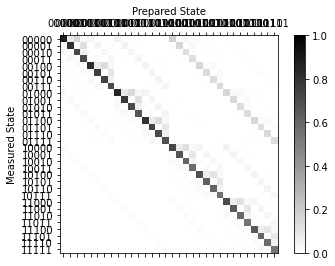

In [13]:
# get measurement filter
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter
print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

In the calibration plot you can see the correct outcomes on the diagonal, while all incorrect outcomes are off-diagonal. Most of the latter are due to T1 errors depolarizing the states from $|1\rangle$ to $|0\rangle$ during the measurement, which causes the matrix to be asymmetric.

Below, we provide you with an array of noisy counts for four different circuits. Note that as measurement error mitigation is a device-specific error correction, the array you receive depends on the backend that you have used before to create the measurement filter.

**Apply the measurement filter in order to get the mitigated data. Given this mitigated data, choose which error-free outcome would be most likely.**

As there are other types of errors for which we cannot correct with this method, you will not get completely noise-free results, but you should be able to guess the correct results from the trend of the mitigated results.

## i) Consider the first set of noisy counts:

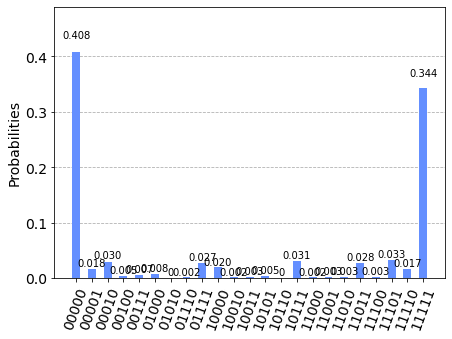

In [29]:
# get noisy counts
noisy_counts = get_counts(backend)
plot_histogram(noisy_counts[0])

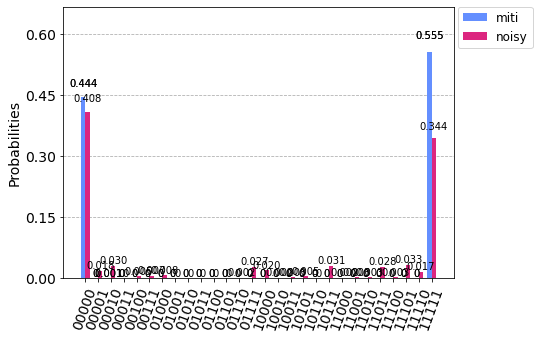

In [61]:
# apply measurement error mitigation and plot the mitigated counts
mitigated_counts_0 = meas_filter.apply(noisy_counts[0])
plot_histogram([mitigated_counts_0, noisy_counts[0]],legend=['miti','noisy'])

## Which of the following histograms most likely resembles the *error-free* counts of the same circuit?
a) <img src="hist_1a.png" width="500"> 
b) <img src="hist_1b.png" width="500"> 
c) <img src="hist_1c.png" width="500"> 
d) <img src="hist_1d.png" width="500">

In [31]:
# uncomment whatever answer you think is correct
#answer1 = 'a'
#answer1 = 'b'
answer1 = 'c'
#answer1 = 'd'

## ii) Consider the second set of noisy counts:

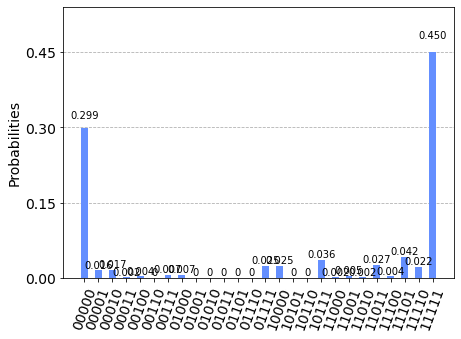

In [32]:
# plot noisy counts
plot_histogram(noisy_counts[1])

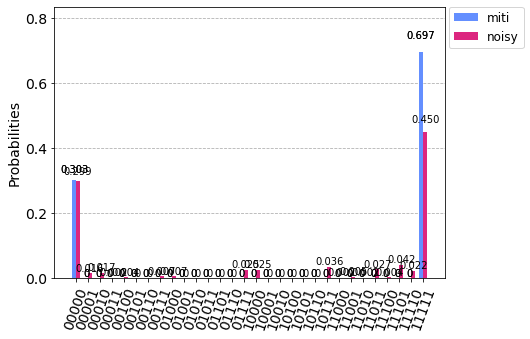

In [62]:
# apply measurement error mitigation
# insert your code here to do measurement error mitigation on noisy_counts[1]
mitigated_counts_1 = meas_filter.apply(noisy_counts[1])
plot_histogram([mitigated_counts_1, noisy_counts[1]],legend=['miti','noisy'])

## Which of the following histograms most likely resembles the *error-free* counts of the same circuit?
a) <img src="hist_2a.png" width="500"> 
b) <img src="hist_2b.png" width="500"> 
c) <img src="hist_2c.png" width="500"> 
d) <img src="hist_2d.png" width="500">

In [34]:
# uncomment whatever answer you think is correct
#answer2 = 'a'
#answer2 = 'b'
#answer2 = 'c'
answer2 = 'd'

## iii) Next, consider the third set of noisy counts:

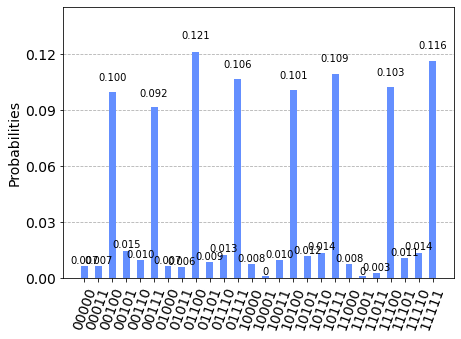

In [35]:
# plot noisy counts
plot_histogram(noisy_counts[2])

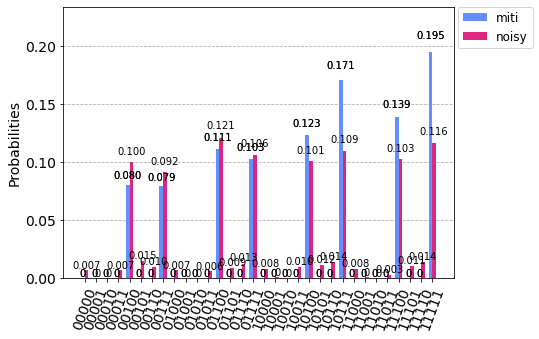

In [47]:
# apply measurement error mitigation
# insert your code here to do measurement error mitigation on noisy_counts[2]
mitigated_counts_2 = meas_filter.apply(noisy_counts[2])
plot_histogram([mitigated_counts_2, noisy_counts[2]],legend=['miti','noisy'])

## Which of the following histograms most likely resembles the *error-free* counts of the same circuit?
a) <img src="hist_3a.png" width="500"> 
b) <img src="hist_3b.png" width="500"> 
c) <img src="hist_3c.png" width="500"> 
d) <img src="hist_3d.png" width="500">

In [65]:
# uncomment whatever answer you think is correct
#answer3 = 'a'
answer3 = 'b'
#answer3 = 'c'
#answer3 = 'd'

## iv) Finally, consider the fourth set of noisy counts:

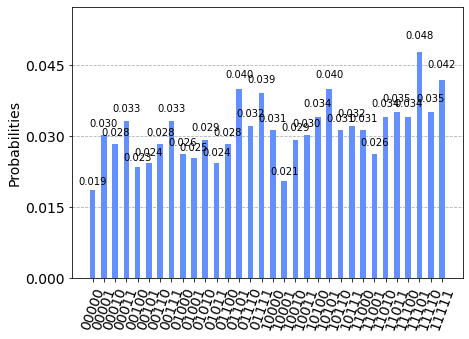

In [66]:
# plot noisy counts
plot_histogram(noisy_counts[3])

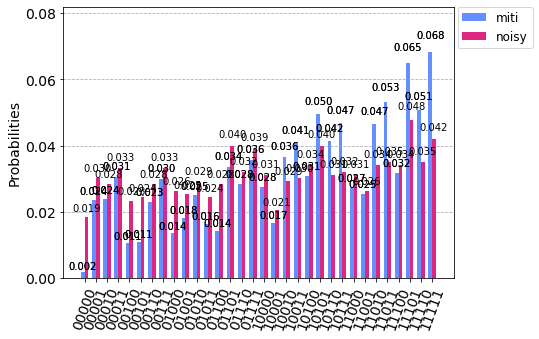

In [67]:
# apply measurement error mitigation
# insert your code here to do measurement error mitigation on noisy_counts[3]
mitigated_counts_3 = meas_filter.apply(noisy_counts[3])
plot_histogram([mitigated_counts_3, noisy_counts[3]],legend=['miti','noisy'])

## Which of the following histograms most likely resembles the *error-free* counts of the same circuit?
a) <img src="hist_4a.png" width="500"> 
b) <img src="hist_4b.png" width="500"> 
c) <img src="hist_4c.png" width="500"> 
d) <img src="hist_4d.png" width="500">

In [68]:
# uncomment whatever answer you think is correct
#answer4 = 'a'
answer4 = 'b'
#answer4 = 'c'
#answer4 = 'd'

The answer string of this exercise is just the string of all four answers. Copy and paste the output of the next line on the IBM Quantum Challenge page to complete the exercise and track your progress.

In [69]:
# answer string
show_final_answer(answer1, answer2, answer3, answer4)

Now that you are done, move on to the next exercise!